In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import isnan

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator, FullBatchNodeGenerator
from stellargraph.layer import GraphSAGE, GCN, GAT
from stellargraph import globalvar

from keras import layers, optimizers, losses, metrics, Model, models
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing, feature_extraction
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

/home/aveek/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/aveek/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aveek/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aveek/anaconda3/lib/python3.6/site-packages/

## Generate Networkx graph

In [2]:

G = nx.read_gml('datasets/verified.gml')

In [3]:
G.number_of_nodes(), G.number_of_edges()

(2901, 148998)

## Features dataset

In [4]:

df = pd.read_csv("datasets/verified_features_all_300k.csv")


In [5]:
df.head()

,uid,name,friends_count,followers_count,listed_count,statuses_count,fake,desc_subjectivity,desc_polarity,tweets_subjectivity,...,weapon_empath,children_empath,monster_empath,ocean_empath,giving_empath,contentment_empath,writing_empath,rural_empath,positive_emotion_empath,musical_empath
0,1172796973,PTorresTV,548,1117,25,12136,0,0.0,0.0,0.312530,...,0.002391,0.021099,0.001657,0.001920,0.003702,0.000585,0.002335,0.002460,0.007839,0.011049
1,1070586199,EOnlineUK,353,102733,316,60989,0,0.0,0.0,0.301738,...,0.002308,0.021205,0.002619,0.002023,0.005247,0.000557,0.002802,0.002584,0.009525,0.013514
2,25589776,people,1751,7565880,33588,267090,1,0.0,0.0,0.324708,...,0.002769,0.032744,0.000474,0.001301,0.002765,0.000771,0.004536,0.005398,0.009638,0.008561
3,1367531,FoxNews,398,18416786,65345,418052,0,0.0,0.0,0.214538,...,0.002891,0.004289,0.001988,0.001589,0.001920,0.000191,0.003285,0.004726,0.002932,0.018821
4,20012204,usweekly,1177,2181224,11975,188328,1,0.9,0.5,0.264836,...,0.000750,0.035524,0.000372,0.002707,0.002477,0.000550,0.005693,0.001944,0.007702,0.008623


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2902 entries, 0 to 2901
Columns: 205 entries, uid to musical_empath
dtypes: float64(198), int64(6), object(1)
memory usage: 4.5+ MB


### If some nodes are there in the graph but missing from the features dataset or vice versa, remove those nodes

In [7]:
names = list(df['name'].values)

In [8]:
sub_g = G.subgraph(names)

In [9]:
sub_g.number_of_nodes(), sub_g.number_of_edges()

(2900, 148998)

In [10]:
# df[]
nodes = list(sub_g.nodes())

df = df[df['name'].isin(nodes)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2900 entries, 0 to 2901
Columns: 205 entries, uid to musical_empath
dtypes: float64(198), int64(6), object(1)
memory usage: 4.6+ MB


In [11]:
df = df[df['name'].isin(nodes)]
names = list(df['name'].values)


In [12]:
names[0]

'PTorresTV'

In [13]:
# int(df['fake'][df['name'] == names[0]])
len(names)

2900

In [14]:
# G.node['PTorresTV']

### Add the labels to the nodes as attributes
These labels will come in handy while doing analysis in Gephi

In [15]:
for n in names:
    G.node[n]['fake'] = int(df['fake'][df['name'] == n])

In [16]:
# G.node['PTorresTV']
# nx.write_gml(G, "datasets/verified_fake_labels.gml")

### Use power transform
Since most of the features have a log-normal distribution, a power scalar is used to transform it into a gausian distribution

In [17]:
pt = preprocessing.PowerTransformer(method='yeo-johnson', 
                                    standardize=True)

# pt = StandardScaler()

In [18]:
# values = df.drop(columns=['name', 'fake']).values
values = df.drop(columns=['name', 'fake', 'uid']).values

values_log = pt.fit_transform(values)

/home/aveek/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [19]:
df = df.reindex(columns=['fake'] + [ x for x in df.columns if x!='fake'])

In [20]:
# df[df.columns[3:]]
# df[df.columns[2:]]

In [21]:
# df[df.columns[2:]] = values_log
df[df.columns[3:]] = values_log
df.head()

,fake,uid,name,friends_count,followers_count,listed_count,statuses_count,desc_subjectivity,desc_polarity,tweets_subjectivity,...,weapon_empath,children_empath,monster_empath,ocean_empath,giving_empath,contentment_empath,writing_empath,rural_empath,positive_emotion_empath,musical_empath
0,0,1172796973,PTorresTV,-0.581919,0.0,-2.234139,-1.296596,-0.914136,-0.427085,0.254067,...,0.406367,0.763588,3.025715,1.836441,0.862621,3.076810,-0.095552,0.513257,1.223009,0.979839
1,0,1070586199,EOnlineUK,-0.874906,0.0,-0.443690,0.013101,-0.914136,-0.427085,0.190879,...,0.379360,0.768702,3.556915,1.903542,1.214578,2.984755,-0.002623,0.554156,1.410441,1.174976
2,1,25589776,people,0.368048,0.0,2.312629,1.419716,-0.914136,-0.427085,0.324428,...,0.524213,1.211943,1.225343,1.350129,0.594292,3.590871,0.308841,1.260611,1.421453,0.733738
3,0,1367531,FoxNews,-0.798181,0.0,2.652388,1.890891,-0.914136,-0.427085,-0.350354,...,0.560568,-0.408646,3.264151,1.596237,0.308552,1.245072,0.089344,1.125324,0.329907,1.473822
4,1,20012204,usweekly,0.011520,0.0,1.761383,1.067187,1.608799,1.562750,-0.031281,...,-0.209424,1.291108,0.956071,2.268944,0.501842,2.960290,0.490076,0.331768,1.205752,0.740579


After the power transform

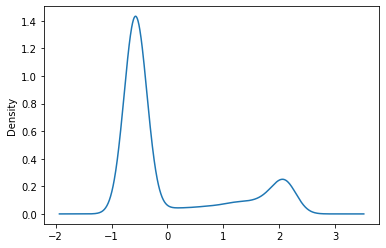

In [22]:
ax = plt.gca()

df['money_empath'].plot.kde()

plt.show()


In [23]:
df.index = df.index.map(str)
df = df.set_index('name')

In [24]:
df.index.names = [None]

In [25]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2900 entries, PTorresTV to LA_Beth
Columns: 204 entries, fake to musical_empath
dtypes: float64(202), int64(2)
memory usage: 4.5+ MB
None


In [26]:
# user_features
# train_data

In [27]:
df = df.astype({'fake': int})

In [28]:
user_features = df.drop(columns=['fake', 'uid'])
# user_features = df.drop(columns=['fake'])

user_target = df['fake']

## Graph Neural Networks

### Split into training and testing sets

In [29]:
train_data, test_data, train_targets, test_targets = train_test_split(user_features,
                                         user_target,
                                         test_size=0.2,
                                         random_state=1)

train_targets= train_targets.values.reshape((-1,1))
test_targets= test_targets.values.reshape((-1,1))


train_targets.shape, test_targets.shape, train_data.shape, test_data.shape

((2320, 1), (580, 1), (2320, 202), (580, 202))

In [30]:
stg = sg.StellarGraph(sub_g, node_features=df.drop(columns=['fake', 'uid']))

### Create the model

In [31]:
model_type = 'graphsage'    # Can be either gcn, gat, or graphsage


In [32]:

if model_type == "graphsage":
    # For GraphSAGE model
    batch_size = 30; 
    num_samples = [20, 10]
    epochs = 30
    
    generator = GraphSAGENodeGenerator(stg, batch_size, num_samples)
    train_gen = generator.flow(train_data.index, 
                               train_targets, 
                               shuffle=True)
    
    base_model = GraphSAGE(
        layer_sizes=[64, 64],
        generator=train_gen,
        bias=True,
        dropout=0.5,
    )
    x_inp, x_out = base_model.default_model(flatten_output=True)
    prediction = layers.Dense(units=1, activation="sigmoid")(x_out)
    
elif model_type == "gcn":
    # For GCN model
    epochs = 50 
    
    generator = FullBatchNodeGenerator(stg, method="gcn", sparse=True)
    train_gen = generator.flow(train_data.index, 
                               train_targets, )
    
    base_model = GCN(
        layer_sizes=[64, 32],
        generator = generator,
        bias=True,
        dropout=0.2,
        activations=["elu", "elu"]
    )
    x_inp, x_out = base_model.node_model()
    prediction = layers.Dense(units=1, activation="sigmoid")(x_out)
    
elif model_type == "gat":
    # For GAT model
    layer_sizes = [8, 1]
    attention_heads = 8
    epochs = 20
    
    generator = FullBatchNodeGenerator(stg, method="gat", sparse=True)
    train_gen = generator.flow(train_data.index, 
                               train_targets,)
    
    base_model = GAT(
        layer_sizes=layer_sizes,
        attn_heads=attention_heads,
        generator=generator,
        bias=True,
        in_dropout=0.5,
        attn_dropout=0.5,
        activations=["elu", "softmax"],
        normalize=None,
    )
    x_inp, prediction = base_model.node_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [33]:

model = Model(inputs=x_inp, outputs=prediction)

In [34]:
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)

In [35]:
test_gen = generator.flow(test_data.index, test_targets)

### Train

In [36]:
history = model.fit_generator(
    train_gen,
    epochs=30,
    validation_data=test_gen,
    verbose=1,
#     shuffle=False,
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
78/78 [==============================] - 23s 296ms/step - loss: 0.6429 - acc: 0.6397 - val_loss: 0.5882 - val_acc: 0.6966
Epoch 2/30
 2/78 [..............................] - ETA: 58s - loss: 0.5615 - acc: 0.7500

/home/aveek/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.346392). Check your callbacks.
  % delta_t_median)


 4/78 [>.............................] - ETA: 57s - loss: 0.6041 - acc: 0.6833

/home/aveek/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.519610). Check your callbacks.
  % delta_t_median)


 6/78 [=>............................] - ETA: 47s - loss: 0.5954 - acc: 0.6944

/home/aveek/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118978). Check your callbacks.
  % delta_t_median)


78/78 [==============================] - 11s 147ms/step - loss: 0.5909 - acc: 0.6966 - val_loss: 0.5694 - val_acc: 0.7207
Epoch 3/30
 2/78 [..............................] - ETA: 1:05 - loss: 0.5469 - acc: 0.8000

/home/aveek/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.139408). Check your callbacks.
  % delta_t_median)
/home/aveek/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.580723). Check your callbacks.
  % delta_t_median)


78/78 [==============================] - 16s 210ms/step - loss: 0.5780 - acc: 0.7081 - val_loss: 0.5688 - val_acc: 0.7103
Epoch 4/30
78/78 [==============================] - 8s 98ms/step - loss: 0.5684 - acc: 0.7145 - val_loss: 0.5563 - val_acc: 0.7190
Epoch 5/30
 3/78 [>.............................] - ETA: 41s - loss: 0.5399 - acc: 0.7778 

/home/aveek/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.141564). Check your callbacks.
  % delta_t_median)
/home/aveek/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.583529). Check your callbacks.
  % delta_t_median)


78/78 [==============================] - 21s 267ms/step - loss: 0.5542 - acc: 0.7256 - val_loss: 0.5584 - val_acc: 0.7172
Epoch 6/30
78/78 [==============================] - 6s 75ms/step - loss: 0.5546 - acc: 0.7222 - val_loss: 0.5536 - val_acc: 0.7379
Epoch 7/30
78/78 [==============================] - 19s 248ms/step - loss: 0.5441 - acc: 0.7325 - val_loss: 0.5587 - val_acc: 0.7259
Epoch 8/30
78/78 [==============================] - 8s 106ms/step - loss: 0.5376 - acc: 0.7389 - val_loss: 0.5480 - val_acc: 0.7293
Epoch 9/30
78/78 [==============================] - 15s 198ms/step - loss: 0.5322 - acc: 0.7423 - val_loss: 0.5709 - val_acc: 0.7155
Epoch 10/30
78/78 [==============================] - 18s 229ms/step - loss: 0.5349 - acc: 0.7355 - val_loss: 0.5595 - val_acc: 0.7207
Epoch 11/30
78/78 [==============================] - 12s 150ms/step - loss: 0.5339 - acc: 0.7376 - val_loss: 0.5516 - val_acc: 0.7190
Epoch 12/30
78/78 [==============================] - 17s 213ms/step - loss: 0.525

In [37]:

# test_metrics = model.evaluate_generator(test_gen)
# print("\nTest Set Metrics:")
# for name, val in zip(model.metrics_names, test_metrics):
#     print("\t{}: {:0.4f}".format(name, val))

### Plot training and validation

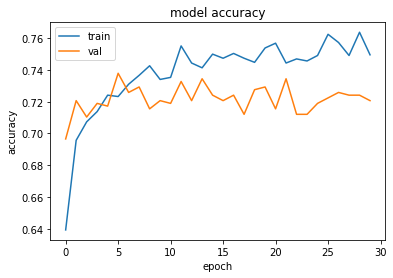

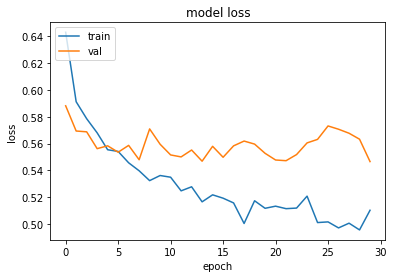

In [38]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

### Calculate evaluation metrics

In [39]:

all_nodes = df.drop(columns=['fake','uid']).index
all_gen = generator.flow(all_nodes)

In [40]:
all_predictions = model.predict_generator(all_gen).squeeze()[..., np.newaxis]

In [41]:
all_predictions.shape

(2900, 1)

In [42]:
# df.drop(columns=['fake'])

In [43]:
all_predictions_df = pd.DataFrame(all_predictions, 
                                  index=df.drop(columns=['fake','uid']).index)

In [44]:
test_preds = all_predictions_df.loc[test_data.index, :]

In [45]:

test_preds.head()

,0
949ThePoint,0.112248
BBCBreaking,0.573235
987fm,0.855391
hburgamerican,0.196456
rachelsklar,0.801137


In [46]:
from numpy import isnan
test_predictions = test_preds.values
where_are_NaNs = isnan(test_predictions)
test_predictions[where_are_NaNs] = 0
test_predictions_class = ((test_predictions>=0.5)*1).flatten()
test_df = pd.DataFrame({"Predicted_score": test_predictions.flatten(), 
                        "Predicted_class": test_predictions_class, 
                        "True": test_targets[:,0]})
roc_auc = metrics.roc_auc_score(test_df['True'].values, 
                                test_df['Predicted_score'].values)
print("The AUC on test set:\n")
print(roc_auc)

The AUC on test set:

0.7882401902497027


In [47]:
# test_df['Predicted_score'].values
# test_predictions_class
# test_df['True'].values

In [48]:

pd.crosstab(test_df['True'], test_df['Predicted_class'])

Predicted_class,0,1
True,,
0,170,120
1,41,249


In [49]:

print('Accuracy: %f' % accuracy_score(test_df['True'], test_df['Predicted_class']))
print('Precision: %f' % precision_score(test_df['True'], test_df['Predicted_class']))
print('Recall: %f' % recall_score(test_df['True'], test_df['Predicted_class']))
print('F1 score: %f' % f1_score(test_df['True'], test_df['Predicted_class']))

# confusion matrix
# print(confusion_matrix(test_df['True'], test_df['Predicted_class']))

Accuracy: 0.722414
Precision: 0.674797
Recall: 0.858621
F1 score: 0.755690


## Visualize learnt embeddings

In [50]:
model.layers

In [51]:
if model_type == 'graphsage':
    # For GraphSAGE, we are going to use the output activations 
    # of the second GraphSAGE layer as the node embeddings
    # x_inp, prediction
    emb_model = Model(inputs=x_inp, outputs=model.layers[-4].output)
    emb = emb_model.predict_generator(generator=all_gen, )
elif model_type == 'gcn':
    # For GCN, we are going to use the output activations of 
    # the second GCN layer as the node embeddings
    emb_model = Model(inputs=x_inp, outputs=model.layers[6].output)
    emb = emb_model.predict_generator(generator=all_gen)
elif model_type == 'gat':
    # For GAT, we are going to use the output activations of the 
    # first Graph Attention layer as the node embeddings
    emb_model = Model(inputs=x_inp, outputs=model.layers[6].output)
    emb = emb_model.predict_generator(generator=all_gen)

In [52]:
emb.shape

(2900, 1, 64)

In [53]:
emb = emb.squeeze()

In [54]:
if model_type == "graphsage":
    emb_all_df = pd.DataFrame(emb, index=df.index)
elif model_type == "gcn" or model_type == "gat":
    emb_all_df = pd.DataFrame(emb, index=stg.nodes())

In [55]:
emb_test = emb_all_df.loc[test_data.index, :]

In [56]:
X = emb_test
y = test_targets
X.shape

(580, 64)

In [57]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [58]:
transform = TSNE # or use PCA 

trans = transform(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(X), index=test_data.index)
emb_transformed['label'] = y

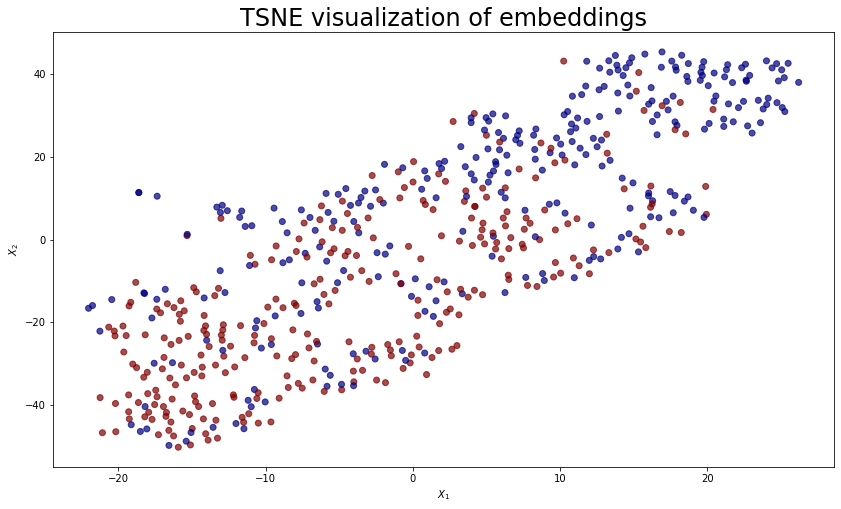

In [59]:

alpha = 0.7

fig, ax = plt.subplots(figsize=(14,8,))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha)
ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of embeddings'.format(transform.__name__), fontsize=24)
plt.show()

## Compare GNN with Logistic regression and SVM

In [60]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import svm

In [61]:
lr = LogisticRegressionCV(cv=5,  
                          max_iter=10000)

In [62]:
lr.fit(train_data, train_targets.ravel())

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [63]:
test_preds_lr = lr.predict_proba(test_data)

In [64]:
lr.score(test_data, test_targets)

0.6862068965517242

In [65]:
# test_preds_lr[:, 1]

In [66]:
test_predictions_class_lr = ((test_preds_lr[:, 1]>=0.5)*1).flatten()
test_df_lr = pd.DataFrame({"Predicted_score": test_preds_lr[:, 1].flatten(), 
                        "Predicted_class": test_predictions_class_lr, 
                        "True": test_targets[:,0]})

In [67]:
pd.crosstab(test_df_lr['True'], test_df_lr['Predicted_class'])

Predicted_class,0,1
True,,
0,178,112
1,70,220


In [68]:
#Create a svm Classifier
clf = svm.SVC(kernel='rbf', gamma='scale')
clf.fit(train_data, train_targets.ravel())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [69]:
y_pred = clf.predict(test_data)

In [70]:
print("Accuracy:", accuracy_score(test_targets.ravel(), y_pred))

Accuracy: 0.7155172413793104


## Logistic regression and SVM with learnt embeddings

In [71]:
emb_train = emb_all_df.loc[train_data.index, :]

In [72]:
# train_data
# emb_train
feat_train = train_data.merge(emb_train, left_index=True, right_index=True, how='inner')

In [73]:
feat_test = test_data.merge(emb_test, left_index=True, right_index=True, how='inner')

In [74]:
lr_emb = LogisticRegressionCV(cv=5,  
                          max_iter=10000)

In [75]:
lr_emb.fit(emb_train, train_targets.ravel())

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [76]:
test_preds_lr = lr_emb.predict_proba(X)

In [77]:
lr_emb.score(X, test_targets)

0.7120689655172414

In [78]:
test_predictions_class_lr = ((test_preds_lr[:, 1]>=0.5)*1).flatten()
test_df_lr = pd.DataFrame({"Predicted_score": test_preds_lr[:, 1].flatten(), 
                        "Predicted_class": test_predictions_class_lr, 
                        "True": test_targets[:,0]})

In [79]:
pd.crosstab(test_df_lr['True'], test_df_lr['Predicted_class'])

Predicted_class,0,1
True,,
0,197,93
1,74,216


In [80]:
#Create a svm Classifier
clf = svm.SVC(kernel='rbf', gamma='scale')
clf.fit(emb_train, train_targets.ravel())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [81]:
y_pred = clf.predict(emb_test)

In [82]:
print("Accuracy:", accuracy_score(test_targets.ravel(), y_pred))

Accuracy: 0.7362068965517241


## Cross validation using stratified K-fold

In [51]:
model_type = "graphsage"

In [38]:
stg = sg.StellarGraph(sub_g, node_features=df.drop(columns=['fake', 'uid']))

In [58]:
if model_type == "graphsage":
    batch_size = 30
    num_samples = [20, 10]
    epochs = 50

    generator = GraphSAGENodeGenerator(stg, batch_size, num_samples)

elif model_type == "gcn":
    # For GCN model
    epochs = 20 
    
    generator = FullBatchNodeGenerator(stg, method="gcn", sparse=True)
    
def create_model(train_data, train_targets):
    
    if model_type == "graphsage":
        train_gen = generator.flow(train_data.index, 
                                   train_targets, 
                                   shuffle=True)

        base_model = GraphSAGE(
            layer_sizes=[64, 64],
            generator=train_gen,
            bias=True,
            dropout=0.5,
        )
        x_inp, x_out = base_model.default_model(flatten_output=True)
        prediction = layers.Dense(units=1, activation="sigmoid")(x_out)

    elif model_type == "gcn":
        # For GCN model
        
        train_gen = generator.flow(train_data.index, 
                                   train_targets, )

        base_model = GCN(
            layer_sizes=[32, 16],
            generator = generator,
            bias=True,
            dropout=0.5,
            activations=["elu", "elu"]
        )
        x_inp, x_out = base_model.node_model()
        prediction = layers.Dense(units=1, activation="sigmoid")(x_out)
        
    model = Model(inputs=x_inp, outputs=prediction)
    return model, train_gen

In [59]:
list_of_lists = []
def test_model(test_data, test_targets):
    
    all_nodes = df.drop(columns=['fake','uid']).index
    all_gen = generator.flow(all_nodes)
    
    all_predictions = model.predict_generator(all_gen).squeeze()[..., np.newaxis]
    all_predictions_df = pd.DataFrame(all_predictions, 
                                  index=df.drop(columns=['fake','uid']).index)
    test_preds = all_predictions_df.loc[test_data.index, :]
    
    test_predictions = test_preds.values
    where_are_NaNs = isnan(test_predictions)
    test_predictions[where_are_NaNs] = 0
    test_predictions_class = ((test_predictions>=0.5)*1).flatten()
    test_df = pd.DataFrame({"Predicted_score": test_predictions.flatten(), 
                            "Predicted_class": test_predictions_class, 
                            "True": test_targets[:,0]})
    roc_auc = metrics.roc_auc_score(test_df['True'].values, 
                                    test_df['Predicted_score'].values)
    acc = accuracy_score(test_df['True'], test_df['Predicted_class'])
    prec = precision_score(test_df['True'], test_df['Predicted_class'])
    recall = recall_score(test_df['True'], test_df['Predicted_class'])
    f1 = f1_score(test_df['True'], test_df['Predicted_class'])
    
    list_of_lists.append([acc, prec,recall, f1, roc_auc])
    
    print('Test- ', 'Accuracy: %f' % acc, 'Precision: %f' % prec, 'Recall: %f' % recall, 'F1 score: %f' % f1 )
    print()

In [60]:
folds = 10

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=folds, shuffle=True)
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(user_features, user_target)):
    print ("Training on fold " + str(index+1) + "/" + str(folds) +"...")
    # Generate batches from indices
    train_data, train_targets = user_features.iloc[train_indices], user_target.iloc[train_indices]
    test_data, test_targets = user_features.iloc[val_indices], user_target.iloc[val_indices]
    train_targets= train_targets.values.reshape((-1,1))
    test_targets= test_targets.values.reshape((-1,1))
    # Clear model, and create it
    model = None
    model, train_gen = create_model(train_data, train_targets)
    model.compile(
        optimizer=optimizers.Adam(lr=0.005),
        loss=losses.binary_crossentropy,
        metrics=["acc"],
    )
    
#     model.compile(
#         optimizer='adam',
#         loss='binary_crossentropy',
#         metrics=["acc"],
#     )
    test_gen = generator.flow(test_data.index, test_targets)
    
    history = model.fit_generator(
        train_gen,
        epochs=50,
        validation_data=test_gen,
        verbose=0,
    #     shuffle=False,
    )
    
    test_model(test_data, test_targets)
    


Training on fold 1/10...
Test-  Accuracy: 0.714777 Precision: 0.696809 Recall: 0.834395 F1 score: 0.759420

Training on fold 2/10...
Test-  Accuracy: 0.735395 Precision: 0.706186 Recall: 0.872611 F1 score: 0.780627

Training on fold 3/10...
Test-  Accuracy: 0.735395 Precision: 0.706186 Recall: 0.872611 F1 score: 0.780627

Training on fold 4/10...
Test-  Accuracy: 0.762887 Precision: 0.741758 Recall: 0.859873 F1 score: 0.796460

Training on fold 5/10...
Test-  Accuracy: 0.758621 Precision: 0.731183 Recall: 0.871795 F1 score: 0.795322

Training on fold 6/10...
Test-  Accuracy: 0.748276 Precision: 0.715026 Recall: 0.884615 F1 score: 0.790831

Training on fold 7/10...
Test-  Accuracy: 0.712803 Precision: 0.681592 Recall: 0.878205 F1 score: 0.767507

Training on fold 8/10...
Test-  Accuracy: 0.716263 Precision: 0.703297 Recall: 0.820513 F1 score: 0.757396

Training on fold 9/10...
Test-  Accuracy: 0.719723 Precision: 0.696335 Recall: 0.852564 F1 score: 0.766571

Training on fold 10/10...
Te

In [61]:
scores = pd.DataFrame(list_of_lists, columns=['Accuracy','Precision','Recall','F1', 'AUC'])

In [62]:
scores

,Accuracy,Precision,Recall,F1,AUC
0,0.714777,0.696809,0.834395,0.759420,0.774884
1,0.735395,0.706186,0.872611,0.780627,0.815952
2,0.735395,0.706186,0.872611,0.780627,0.770891
3,0.762887,0.741758,0.859873,0.796460,0.818614
4,0.758621,0.731183,0.871795,0.795322,0.813816
5,0.748276,0.715026,0.884615,0.790831,0.804679
6,0.712803,0.681592,0.878205,0.767507,0.768797
7,0.716263,0.703297,0.820513,0.757396,0.791353
8,0.719723,0.696335,0.852564,0.766571,0.792703
9,0.733564,0.698492,0.891026,0.783099,0.763302


### Average, std deviation, max and min values for evaluation metrics

In [63]:
scores.describe().loc[['mean', 'std', 'min', 'max']]

,Accuracy,Precision,Recall,F1,AUC
mean,0.733770,0.707686,0.863821,0.777786,0.791499
std,0.018213,0.017649,0.022314,0.014357,0.021128
min,0.712803,0.681592,0.820513,0.757396,0.763302
max,0.762887,0.741758,0.891026,0.796460,0.818614


## Final accuracy

In [ ]:
# print("Model Accuracy: " + str(round(, 2)))